Testing FIBSEM Microscope overall class
    - Testing Thermo Fisher instance of class
    

Importing Relevant Modules

In [3]:
%load_ext autoreload
%autoreload 2

import fibsem
from fibsem import utils, acquire
import fibsem.alignment as fa
from fibsem.structures import BeamType, ImageSettings, FibsemRectangle, FibsemImage, check_data_format, FibsemStagePosition
import matplotlib.pyplot as plt
from fibsem import FibsemMicroscope, calibration
import os
import logging
from fibsem.utils import current_timestamp, configure_logging
from pathlib import Path
from autoscript_sdb_microscope_client.structures import (
    AdornedImage,
    GrabFrameSettings,
    Rectangle,
    RunAutoCbSettings,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing settings from config

In [4]:
settings = utils.load_settings_from_config()


# Testing Milling 

In [5]:
microscope, settings = utils.setup_session()

2023-01-31 14:27:35,458 — root — INFO — setup_session:162 — Finished setup for session: demo_2023-01-31-02-27-35PM


In [ ]:
microscope.move_flat_to_beam(beam_type=BeamType.ELECTRON)

In [5]:
from FibsemMilling import setup_milling, run_milling, finish_milling, draw_rectangle, milling_protocol
from structures import MillingSettings

In [7]:
image_settings = settings.image
image_settings.reduced_area = FibsemRectangle(0, 0, 100, 100)
# mill_settings = MillingSettings(
#     width = 10e-6, # 1 mm
#     height = 10e-6, # 1 mm
#     depth = 0.1e-6, # 1 mm
#     rotation = 0, # radians?
#     centre_x = 0,
#     centre_y = 0,
#     milling_current = 2e-9,
#     scan_direction = "TopToBottom",
#     cleaning_cross_section = False
# )

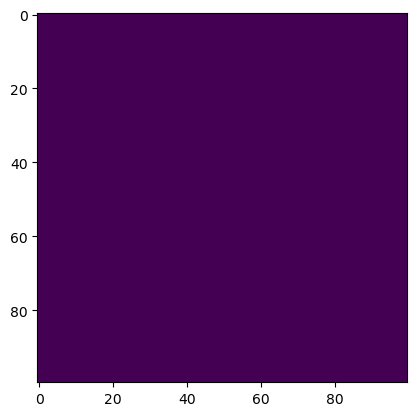

In [10]:
eb_image = acquire.new_image(microscope, image_settings)
image_settings.beam_type = BeamType.ION
# ib_image = acquire.new_image(microscope, image_settings)

plt.imshow(eb_image.data)
# plt.imshow(ib_image.data)

plt.show()


In [7]:
# setup milling
hfw = image_settings.hfw
setup_milling(microscope, hfw=hfw, mill_settings=mill_settings)



2023-01-24 14:35:27,923 — root — INFO — setup_milling:39 — setup ion beam milling
2023-01-24 14:35:27,923 — root — INFO — setup_milling:40 — application file:  autolamella, pattern mode: Serial, hfw: 0.00015


In [8]:
# draw patterns NOTE: Currently only implementing rectangle pattern
draw_rectangle(microscope, mill_settings)



In [9]:
# run milling
run_milling(microscope, mill_settings.milling_current)



 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100% Finished


In [10]:
# finish milling
finish_milling(microscope)

2023-01-24 14:35:37,332 — root — INFO — finish_milling:71 — changing to imaging current: 2.00e-11
2023-01-24 14:35:37,333 — root — INFO — finish_milling:73 — finished ion beam milling.


In [12]:
milling_protocol(microscope, image_settings, mill_settings, application_file="autolamella", patterning_mode="Serial")

2023-01-24 14:36:35,847 — root — INFO — setup_milling:39 — setup ion beam milling
2023-01-24 14:36:35,847 — root — INFO — setup_milling:40 — application file:  autolamella, pattern mode: Serial, hfw: 0.00015
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100% Finished
2023-01-24 14:36:37,325 — root — INFO — finish_milling:71 — changing to imaging current: 2.00e-11
2023-01-24 14:36:37,326 — root — INFO — finish_milling:73 — finished ion beam milling.


# Finished Milling Testing

In [8]:
position = FibsemStagePosition(0.001, 0.0, 0.010, 0.0, 0.0)
microscope.move_stage_absolute(position)

microscope.move_stage_relative(0.003, 0.0, 0.0, 0.0, 45)

microscope.eucentric_move(settings, 0.003, 0.001, BeamType.ELECTRON)

2023-01-12 13:52:24,315 — root — INFO — eucentric_move:646 — moving stage (ELECTRON): FibsemStagePosition(x=0.003, y=0.0008919563855811247, z=0.0006245545849381899, r=None, t=None, coordinate_system=None)


In [ ]:
print(microscope.connection.SEM.Beam.GetStatus())

Setting up for image acquisition

In [ ]:
print(settings)

In [ ]:
# set gamma settings
gamma_settings = GammaSettings(
        enabled=True,
        min_gamma=0.5,
        max_gamma=1.8,
        scale_factor=0.01,
        threshold=46,
    )

# set imaging settings
image_settings = ImageSettings(
        resolution=(1536,1024),
        dwell_time=1.0e-6,
        hfw=300.0e-6,
        autocontrast=True,
        beam_type=BeamType.ION,
        gamma=gamma_settings,
        save=True,
        save_path="fibsem\\test_images",
        label=utils.current_timestamp(),
        reduced_area=None,
    )


Autoconcrast

In [ ]:
microscope.autocontrast(beam_type=image_settings.beam_type)
microscope.autocontrast(beam_type=BeamType.ION)


Take new image

In [ ]:
new_image = acquire.new_image(microscope, image_settings)

plt.imshow(new_image.data)
plt.show()


Checks

In [ ]:
assert isinstance(new_image, FibsemImage)
assert check_data_format(new_image.data)

assert new_image.metadata.compare_image_settings(image_settings)
assert new_image.metadata.version == 'v1'
assert os.path.exists(f"{os.path.join(image_settings.save_path, image_settings.label)}_eb.tif")
#assert new_image.metadata.microscope_state.absolute_position == microscope.get_stage_position()

print(new_image.metadata.microscope_state)

Take last image

In [ ]:
label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    last_image.save(save_path=filename)


Checks

In [ ]:
# assert isinstance(last_image, FibsemImage)
assert check_data_format(last_image.data)


# assert last_image.metadata.compare_image_settings(image_settings) # TODO: FIX THIS, different than img settings
assert last_image.metadata.version == 'v1'
assert os.path.exists(f"{filename}.tif")

print(last_image.metadata.microscope_state)

In [ ]:
params = microscope.connection.FIB.Optics.EnumParameters()
print(new_image.metadata.microscope_state.ib_settings.working_distance)
print(microscope.connection.FIB.Optics.Get(1))
print(params)
print(params.find('Working Distance'))


In [ ]:
# find index
split_params = params.split("\n")
for i, word in enumerate(split_params):
    if "Working Distance" in word:
        idx = int(word.split(".")[1])
        count = int(split_params[i+1].split("=")[-1]) - 1
        unit = split_params[i+2].split("=")[-1]
# get index
print(count)
wd = microscope.connection.FIB.Optics.Get(idx)[count]

print(f"wd: {wd}{unit}")



Take reference images

In [ ]:
#taking set of ref images
hfws =  [400e-6, 150.0e-6]
ref_images = acquire.take_set_of_reference_images(microscope, image_settings,hfws)
fig = plt.figure(figsize=(10, 7))

print(ref_images)

fig.add_subplot(2, 2, 1)
plt.imshow(ref_images.low_res_eb.data)
fig.add_subplot(2, 2, 2)
plt.imshow(ref_images.high_res_eb.data)
fig.add_subplot(2, 2, 3)
plt.imshow(ref_images.low_res_ib.data)
fig.add_subplot(2, 2, 4)
plt.imshow(ref_images.high_res_ib.data)

#checking image data 
# if ref_images.low_res_eb.metadata.compare_image_settings(image_settings):
#     print("Image settings are the same")
# print(ref_images[0].metadata.microscope_state.timestamp)
# print(ref_images[0].metadata.version)


assert ref_images.low_res_eb.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_eb.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.low_res_ib.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_ib.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.high_res_eb.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_eb.metadata.image_settings.hfw} != {hfws[1]}"
assert ref_images.high_res_ib.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_ib.metadata.image_settings.hfw} != {hfws[1]}"


Beam shift

In [ ]:
print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

microscope.reset_beam_shifts()

print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

assert microscope.connection.beams.electron_beam.beam_shift.value.x == 0
assert microscope.connection.beams.electron_beam.beam_shift.value.y ==  0

assert microscope.connection.beams.ion_beam.beam_shift.value.x == 0
assert microscope.connection.beams.ion_beam.beam_shift.value.y ==  0

Disconnect from Microscope

In [ ]:
microscope.disconnect()